In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

In [2]:
df=pd.read_csv("models_cc_data/df_cc_init.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df

id  device_id  active_power  direct_power  charge_capacity     T  \
0     19128          6         65.24         66.29            195.2  31.2   
1     19129          7         72.97         74.12            196.3  31.2   
2     19130          8         65.92         66.98            199.0  31.2   
3     19131          9         72.45         73.67            232.2  31.2   
4     19132         10         60.01         60.98            182.0  31.2   
...     ...        ...           ...           ...              ...   ...   
2390  50268          6          8.44          8.78             55.4   8.0   
2391  50269          7          7.66          7.94             55.2   8.0   
2392  50270          8          8.21          8.45             54.5   8.0   
2393  50271          9          9.55          9.84             58.0   8.0   
2394  50272         10          8.81          9.05             56.2   8.0   

         U   Ff  RRR  DD_WE  ...  active_power_b   T_b   U_b  Ff_b  RRR_b  \
0     60.0  2.0  0.0      1  ...           31.25  27.5  83.0   0.0    0.0   
1     60.0  2.0  0.0      1  ...           35.22  27.5  83.0   0.0    0.0   
2     60.0  2.0  0.0      1  ...           39.62  27.5  83.0   0.0    0.0   
3     60.0  2.0  0.0      1  ...           50.39  27.5  83.0   0.0    0.0   
4     60.0  2.0  0.0      1  ...           25.24  27.5  83.0   0.0    0.0   
...    ...  ...  ...    ...  ...             ...   ...   ...   ...    ...   
2390  96.0  2.0  4.0      1  ...            4.75   8.5  98.0   2.0    5.0   
2391  96.0  2.0  4.0      1  ...            4.74   8.5  98.0   2.0    5.0   
2392  96.0  2.0  4.0      1  ...            4.91   8.5  98.0   2.0    5.0   
2393  96.0  2.0  4.0      1  ...            5.23   8.5  98.0   2.0    5.0   
2394  96.0  2.0  4.0      1  ...            4.87   8.5  98.0   2.0    5.0   

      DD_WE_b  DD_NS_b  Po(p)_b   POA_b  hour  
0        -1.0      0.0   996.39  441.37    11  
1        -1.0      0.0   996.39  441.37    11  
2        -1.0      0.0   996.39  441.37    11  
3        -1.0      0.0   996.39  441.37    11  
4        -1.0      0.0   996.39  441.37    11  
...       ...      ...      ...     ...   ...  
2390      1.0      0.0  1011.46  959.15    14  
2391      1.0      0.0  1011.46  959.15    14  
2392      1.0      0.0  1011.46  959.15    14  
2393      1.0      0.0  1011.46  959.15    14  
2394      1.0      0.0  1011.46  959.15    14  

[2395 rows x 24 columns]

In [53]:
features = ['T', 'U', 'Ff',	'RRR', 'DD_WE', 'DD_NS', 'POA', 'Po(p)', 'hour',
            'T_b', 'U_b', 'Ff_b', 'RRR_b', 'DD_WE_b', 'DD_NS_b', 'POA_b', 'Po(p)_b', 'device_id']

X = df[features]
y = df['cc_diff']

X = X.fillna(X.mean())
y = y.fillna(y.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=77)


In [6]:
def neg_mse_non_negative(y_true, y_pred):
    y_pred_non_negative = np.maximum(0, y_pred)
    return -mean_squared_error(y_true, y_pred_non_negative)
non_negative_mse_scorer = make_scorer(neg_mse_non_negative, greater_is_better=True)

In [63]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_neighbors': range(1, 40),  # uniform discrete random variables
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'leaf_size': range(1, 50),
    'p': [1, 2]
}

# Define the model
knn = KNeighborsRegressor()

# Define the scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Setup the randomized search
knn_random = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=100, cv=5, scoring=scorer, n_jobs=-1)

# Fit the random search to the data
knn_random.fit(X, y)

# Print the best parameters and the best score
print("KNN:")
print("Best parameters:", knn_random.best_params_)
print("RMSE:", np.sqrt(-knn_random.best_score_))

# Use the best parameters for your model
knn_best = knn_random.best_estimator_

y_pred = knn_best.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
# print('MAPE:', np.mean(np.abs((y_test - y_pred)/y_test)))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))



knn2 = KNeighborsRegressor()

# Define the scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Setup the randomized search
knn_random2 = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=100, cv=5, scoring=scorer, n_jobs=-1)

# Fit the random search to the data
knn_random2.fit(X_train, y_train)

# Print the best parameters and the best score
print()
print("KNN_traindata:")
print("Best parameters:", knn_random2.best_params_)
print("RMSE:", np.sqrt(-knn_random2.best_score_))

# Use the best parameters for your model
knn_best2 = knn_random2.best_estimator_
y_pred = knn_best2.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
# print('MAPE:', np.mean(np.abs((y_test - y_pred)/y_test)))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

knn3 = KNeighborsRegressor()

# Define the scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Setup the randomized search
knn_random3 = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=100, cv=5, scoring=scorer, n_jobs=-1)

# Fit the random search to the data
knn_random3.fit(X_test, y_test)

# Print the best parameters and the best score
print()
print("KNN_testdata:")
print("Best parameters:", knn_random3.best_params_)
print("RMSE:", np.sqrt(-knn_random3.best_score_))

# Use the best parameters for your model
knn_best3 = knn_random3.best_estimator_
y_pred = knn_best3.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
# print('MAPE:', np.mean(np.abs((y_test - y_pred)/y_test)))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

KNN:
Best parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 37, 'metric': 'minkowski', 'leaf_size': 33}
RMSE: 42.05104285026259
MAE: 0.0
MSE: 0.0
RMSE: 0.0
R2: 1.0

KNN_traindata:
Best parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'metric': 'manhattan', 'leaf_size': 13}
RMSE: 16.361016068429993
MAE: 7.536710793878673
MSE: 237.39241630237416
RMSE: 15.407544135986571
R2: 0.9563126713666998

KNN_testdata:
Best parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 4, 'metric': 'manhattan', 'leaf_size': 35}
RMSE: 24.19654418144799
MAE: 0.0
MSE: 0.0
RMSE: 0.0
R2: 1.0


In [49]:
from sklearn.model_selection import cross_val_score
param={'leaf_size': 38, 'metric': 'manhattan', 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
knn = KNeighborsRegressor(**param)
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores
print(mse_scores)
print("Mean Squared Error: %0.2f (+/- %0.2f)" % (np.sqrt(mse_scores.mean()), np.sqrt(mse_scores.std() * 2)))

[180.63626142 246.99782792 283.41224231 234.36763037 316.32478732]
Mean Squared Error: 15.89 (+/- 9.59)


In [16]:
from sklearn.tree import DecisionTreeRegressor

param_distributions = {
    'max_depth': [None, 10, 20, 30, 40, 50],  # None means no maximum depth
    'min_samples_split': np.arange(2, 11),    # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 11),     # Minimum number of samples required to be at a leaf node
    'max_features': [None, 1, 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'criterion': ['squared_error']  # Function to measure the quality of a split
}

# Create a DecisionTreeRegressor instance
dt = DecisionTreeRegressor(random_state=100)

# Set up the RandomizedSearchCV instance
dt_random = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Can change to other metrics
    cv=5,  # Number of folds in cross-validation
    random_state=100,
    verbose=1  # For logging output
)

# Fit the RandomizedSearchCV instance to the training data
dt_random.fit(X, y)

# Print the best parameters and the corresponding score
print("Best parameters:", dt_random.best_params_)
print("RMSE:", np.sqrt(-dt_random.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None, 'max_depth': 50, 'criterion': 'squared_error'}
RMSE: 38.38728179131814


In [17]:
from sklearn.ensemble import RandomForestRegressor

param_distributions = {
    'n_estimators': [10, 50, 100, 200, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at a leaf node
    'max_features': [1, 'sqrt', 'log2']  # Number of features to consider at every split
}

# Initialize the base model
rf = RandomForestRegressor()

# Create the RandomizedSearchCV model
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                               n_iter=100, cv=5, verbose=2, random_state=100, n_jobs=-1,
                               scoring=make_scorer(mean_squared_error, greater_is_better=False))

# Fit the random search model (replace X_train, y_train with your training data)
rf_random.fit(X, y)

# Best parameters found
print("Best parameters:", rf_random.best_params_)

# Best score achieved
print("RMSE:", np.sqrt(-rf_random.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
RMSE: 32.11473952321619


In [19]:
from sklearn.ensemble import GradientBoostingRegressor

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None]
}

gb = GradientBoostingRegressor()

# RandomizedSearchCV setup
gb_random = RandomizedSearchCV(gb, param_distributions=param_distributions, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, 
                                   n_jobs=-1, scoring=make_scorer(mean_squared_error, greater_is_better=False))

# Fit the model (replace X_train and y_train with your training data)
gb_random.fit(X, y)

# Best parameters
print("Best parameters:", gb_random.best_params_)

# Best score (negative mean squared error)
print("RMSE:", np.sqrt(-gb_random.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 8, 'learning_rate': 0.1}
RMSE: 30.45885280955532


In [47]:
import lightgbm as lgb

param_distributions = {
    'num_leaves': [20, 30, 40, 50, 60],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [-1, 5, 10, 15],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

gbm = lgb.LGBMRegressor()

# RandomizedSearchCV setup
gbm_random = RandomizedSearchCV(estimator=gbm, param_distributions=param_distributions,
                                   n_iter=100, cv=5, verbose=2, random_state=100, 
                                   n_jobs=-1, scoring='neg_mean_squared_error')

gbm_random.fit(X, y)
print("Best parameters:", gbm_random.best_params_)

# Best score
print("RMSE:", np.sqrt(-gbm_random.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1451
[LightGBM] [Info] Number of data points in the train set: 1916, number of used features: 18
[LightGBM] [Info] Start training from score 68.903340
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=15, min_child_samples=30, n_estimators=50, num_leaves=20, subsample=0.8; total time=   0.8s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1400
[LightGBM] [Info] Number of data points in the train set: 1916, number of used features: 18
[LightGBM] [Info] Start tra

In [34]:
X_train

T      U   Ff   RRR  DD_WE  DD_NS     POA    Po(p)  hour   T_b   U_b  \
249   27.8   80.0  1.0   0.0      1      0  450.32  1001.28     8  24.2  94.0   
2075   6.5   72.0  1.0   0.0      1      1    0.00  1014.77    20   8.5  60.0   
30    31.5   67.0  4.0   0.0      1     -1  800.61   996.66    14  32.0  58.0   
2014   5.8   94.0  2.0  20.0     -1      1  938.74  1012.12    11   5.2  96.0   
2297  19.7   67.0  3.0   0.0      1      1  174.76  1000.09    17  20.9  64.0   
...    ...    ...  ...   ...    ...    ...     ...      ...   ...   ...   ...   
350   31.8   60.0  2.0   0.0     -1      1  952.76  1001.55    11  27.8  77.0   
1930   8.5   89.0  0.0   0.1      0      1  335.16  1010.27     8   8.4  94.0   
79    32.3   60.0  1.0   0.0      0     -1  944.99   998.77    11  26.9  80.0   
1859  14.8  100.0  1.0   0.0     -1     -1  330.98  1005.78     8  14.6  99.0   
1544  15.5   80.0  2.0   0.0      1     -1  821.34  1005.78    14  14.5  83.0   

      Ff_b  RRR_b  DD_WE_b  DD_NS_b   POA_b  Po(p)_b  device_id  
249    1.0    0.0     -1.0      0.0    0.00  1000.23         10  
2075   3.0    0.0      1.0      0.0  156.77  1012.65          6  
30     1.0    0.0     -1.0      1.0  943.00   998.24          6  
2014   2.0   17.0     -1.0      1.0  340.05  1012.52         10  
2297   3.0    0.0      1.0      1.0  880.12  1000.23          8  
...    ...    ...      ...      ...     ...      ...        ...  
350    1.0    0.0     -1.0      1.0  453.35  1002.21          6  
1930   2.0    0.1      1.0      1.0    0.00  1009.08          6  
79     1.0    0.0     -1.0     -1.0  444.08   999.17         10  
1859   1.0    0.0     -1.0     -1.0    0.00  1005.12         10  
1544   1.0    0.0      1.0     -1.0  909.52  1008.69         10  

[1916 rows x 18 columns]

In [36]:
y_train

249      24.8
2075      2.2
30      235.9
2014     28.3
2297     92.5
        ...  
350     149.9
1930      1.6
79      170.5
1859      3.1
1544     57.7
Name: cc_diff, Length: 1916, dtype: float64

In [41]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.to_csv("models_cc_data/df_train.csv")

In [45]:
df_test = pd.concat([X_test, y_test], axis=1)
df_test.to_csv("models_cc_data/df_test.csv")

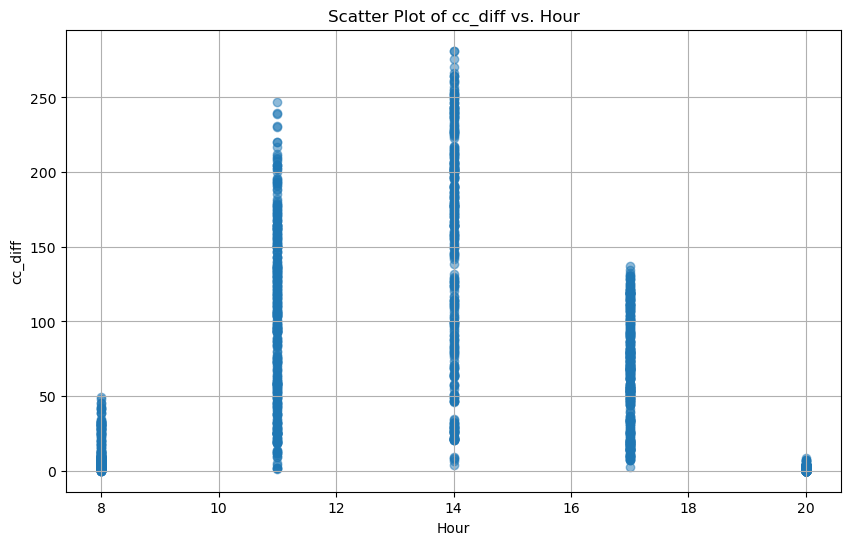

In [43]:
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
plt.scatter(df_train['hour'], df_train['cc_diff'], alpha=0.5)  # alpha is used to adjust the transparency of the points
plt.title('Scatter Plot of cc_diff vs. Hour')  # Adds a title
plt.xlabel('Hour')  # Label for the x-axis
plt.ylabel('cc_diff')  # Label for the y-axis
plt.grid(True)  # Adds a grid for easier reading
plt.show()  # Displays the plot

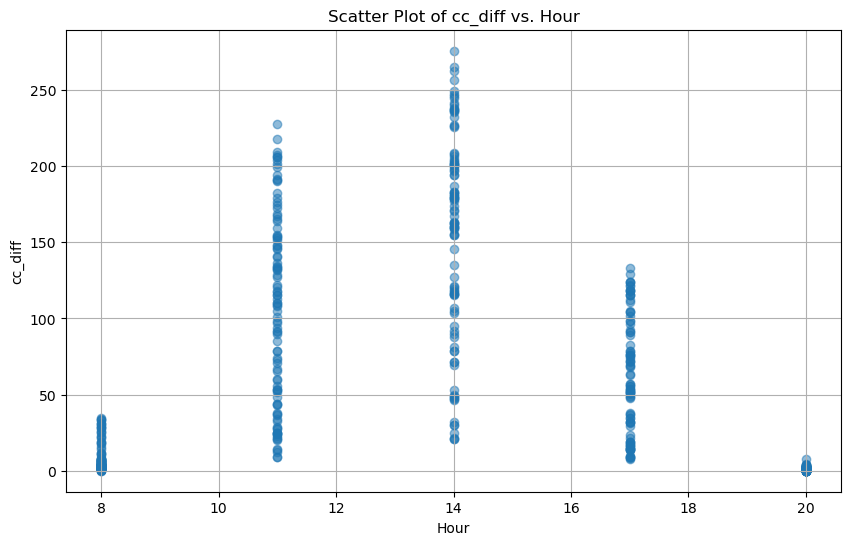

In [46]:
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
plt.scatter(df_test['hour'], df_test['cc_diff'], alpha=0.5)  # alpha is used to adjust the transparency of the points
plt.title('Scatter Plot of cc_diff vs. Hour')  # Adds a title
plt.xlabel('Hour')  # Label for the x-axis
plt.ylabel('cc_diff')  # Label for the y-axis
plt.grid(True)  # Adds a grid for easier reading
plt.show()  # Displays the plot